In [3]:
import pandas as pd
import requests
import folium
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, mapping
from shapely import GeometryCollection, MultiPolygon
import json

In [4]:
PICKLE_PATH = "/Users/abby/Desktop/RAFI/pickled-beef.pickle"
FSIS_DATA = "/Users/abby/Desktop/RAFI/fsis-processors-with-location.csv"

In [5]:
# constants for coordinate projections
ALBERS_EQUAL_AREA = "EPSG:9822"
WGS84 = "EPSG:4326"

#### Load Beef DF

In [6]:
df_large_beef = pd.read_pickle(PICKLE_PATH)

In [7]:
df_large_beef = gpd.GeoDataFrame(df_large_beef).set_geometry("Isochrone")
df_large_beef.head()

,Unnamed: 0,EstNumber,EstID,Parent Corporation,Establishment Name,State,Size,Animals Processed,Processed\nVolume\nCategory,Slaughter\nVolume\nCategory,Full Address,latitude,longitude,Isochrone
0,0,M267,4802,JBS,JBS Tolleson Inc.,AZ,Large,Beef,5.0,4.0,"651 S. 91st Ave, Tolleson, AZ 85353",33.441660,-112.252559,"POLYGON ((-112.13856 34.15987, -112.14262 34.1..."
1,1,M354,5117,Cargill,Cargill Meat Solutions,CA,Large,Beef,5.0,4.0,"3115 S. Fig Ave., Fresno, CA 93706",36.689651,-119.801950,"POLYGON ((-119.63395 37.44892, -119.63480 37.4..."
2,2,M6063A,5289,Central Valley Meat Company,"Central Valley Meat Co., Inc.",CA,Large,Beef,5.0,4.0,"10431 8 3/4 Ave., Hanford, CA 93230",36.321273,-119.612222,"POLYGON ((-119.75322 37.08978, -119.75622 37.0..."
3,3,M783 + P783 + V783,5144,Central Valley Meat Company,Harris Ranch Beef Company,CA,Large,Beef,5.0,4.0,"16277 S McCall Ave., Selma, CA 93662",36.499212,-119.614553,"POLYGON ((-119.69555 37.26998, -119.70455 37.2..."
4,4,M21488 + V21488,8349,Independent,OWB Packers LLC,CA,Large,Beef,4.0,4.0,"57 East Shank Road, Brawley, CA 92227",33.000969,-115.521786,"POLYGON ((-115.44979 33.79233, -115.45100 33.7..."


In [8]:
# set CRS (coordinate reference system) for the dataframe
df_large_beef.set_crs(WGS84,inplace=True).head()

,Unnamed: 0,EstNumber,EstID,Parent Corporation,Establishment Name,State,Size,Animals Processed,Processed\nVolume\nCategory,Slaughter\nVolume\nCategory,Full Address,latitude,longitude,Isochrone
0,0,M267,4802,JBS,JBS Tolleson Inc.,AZ,Large,Beef,5.0,4.0,"651 S. 91st Ave, Tolleson, AZ 85353",33.441660,-112.252559,"POLYGON ((-112.13856 34.15987, -112.14262 34.1..."
1,1,M354,5117,Cargill,Cargill Meat Solutions,CA,Large,Beef,5.0,4.0,"3115 S. Fig Ave., Fresno, CA 93706",36.689651,-119.801950,"POLYGON ((-119.63395 37.44892, -119.63480 37.4..."
2,2,M6063A,5289,Central Valley Meat Company,"Central Valley Meat Co., Inc.",CA,Large,Beef,5.0,4.0,"10431 8 3/4 Ave., Hanford, CA 93230",36.321273,-119.612222,"POLYGON ((-119.75322 37.08978, -119.75622 37.0..."
3,3,M783 + P783 + V783,5144,Central Valley Meat Company,Harris Ranch Beef Company,CA,Large,Beef,5.0,4.0,"16277 S McCall Ave., Selma, CA 93662",36.499212,-119.614553,"POLYGON ((-119.69555 37.26998, -119.70455 37.2..."
4,4,M21488 + V21488,8349,Independent,OWB Packers LLC,CA,Large,Beef,4.0,4.0,"57 East Shank Road, Brawley, CA 92227",33.000969,-115.521786,"POLYGON ((-115.44979 33.79233, -115.45100 33.7..."


In [9]:
# simplify the isochrones for improved processing time
df_large_beef['Isochrone Cleaned'] = df_large_beef['Isochrone'].simplify(.05)

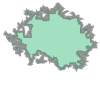

In [10]:
df_large_beef.iloc[0]['Isochrone']

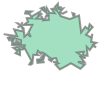

In [12]:
# shows the difference in resolution between the simplified and unsimplified isochrones
df_large_beef.iloc[0]['Isochrone Cleaned']

In [13]:
# list the states that contain poultry plants
df_large_beef.State.unique()

array(['AZ', 'CA', 'CO', 'GA', 'IA', 'ID', 'IL', 'KS', 'MI', 'MN', 'NE',
       'PA', 'SD', 'TX', 'UT', 'WA', 'WI'], dtype=object)

In [14]:
# reassign the dataframe to df_map for processing later in the notebook
df_map = df_large_beef

### Create Map

In [15]:
# center of the USA: 37.0902° N, 95.7129° W
USA_LAT = 37.0902
USA_LNG = -95.7129

In [16]:
# folium requires these "color mapping functions" to add colors to the map
empty_color = lambda x: {
    "fillColor": "00" # empty
}

one_plant_color = lambda x: {
    "fillColor": "#ED7117" # carrot
}

two_plant_color = lambda x: {
    "fillColor": "#ED7117" # carrot
}

three_plant_color = lambda x: {
    "fillColor": "#9F2B68" # amaranth
}

four_plant_color = lambda x: {
    "fillColor": "#90ee90" # light green
}

#### Add Plants to Map Layer and Extract Isochrones for Geospatial Processing

In [68]:
# add markers and isochrones to map
isochrones = []
# driving_distance_layer = folium.map.FeatureGroup(name="60 Mile Driving Distance")
plants_layer = folium.map.FeatureGroup(name="Large Beef Plants")

for index, row in df_map.iterrows():
    lat = str(row['latitude'])
    lng = str(row['longitude'])

    # set up plant tooltip
    name = row['Establishment Name']
    corp = row['Parent Corporation']
    address = row['Full Address']

    # add plant marker to map
    tooltip = folium.map.Tooltip(f"{name}<br>{address}<br>Parent Corporation: {corp}")
    folium.Marker(location=[lat, lng],tooltip=tooltip).add_to(plants_layer)

    isochrone = row['Isochrone Cleaned']
    isochrones.append(isochrone)
    
    # Can add the isochrones to the map, too, but this gets pretty cluttered with the other geospatial data
    # add driving radius isochrone to map layer
    # geojson = folium.GeoJson(row['Isochrone Cleaned'], style_function=empty_color)
    # geojson.add_to(driving_distance_layer)

In [69]:
len(isochrones)

41

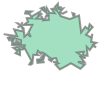

In [70]:
# example isochrone
isochrones[0]

#### Calculate Single-Plant Capture

In [71]:
# create single-plant capture area by removing one plant at a time and saving the area that is unique to that plant
single_plants_shapely = []
for index, poly in enumerate(isochrones):
    others = shapely.unary_union(isochrones[:index] + isochrones[index+1:])
    single_plant = shapely.difference(poly, others)
    single_plants_shapely.append(single_plant)

In [72]:
# create folium layer for single plant capture
single_plant_layer = folium.map.FeatureGroup(name="Access to 1 Plant")
single_plants_combined = shapely.unary_union(single_plants_shapely)
folium.GeoJson(single_plants_combined).add_to(single_plant_layer)

In [73]:
# calculate competitive area for filtering in the next stage
everything = shapely.unary_union(isochrones)
single_plant_combined = shapely.unary_union(single_plants_shapely)
competition_single_plant = shapely.difference(everything, single_plant_combined)

#### Calculate Two Plant Capture

In [74]:
# exclude any plants that are fully in single plant capture area
isochrones_shapely_two_plants = []
for isochrone in isochrones:
    if isochrone.intersection(competition_single_plant):
        isochrones_shapely_two_plants.append(isochrone)

In [75]:
len(isochrones_shapely_two_plants)

24

In [76]:
# logic here is similar to single plant capture with just a bit more complexity since we are now looking at two plant capture so we need to do a nested loop
two_plants_shapely = []
for i in range(len(isochrones_shapely_two_plants)):
    for j in range(i+1, len(isochrones_shapely_two_plants)):
        plant_1 = isochrones_shapely_two_plants[i]
        plant_2 = isochrones_shapely_two_plants[j]

        # check if there's an intersection between the areas
        if not plant_1.intersection(plant_2):
            continue
        else:
            two_plant_area = shapely.unary_union([plant_1,plant_2])

        # exclude first plant
        other_plants = isochrones_shapely_two_plants[:i]
        # exclude second plant
        other_plants += isochrones_shapely_two_plants[i+1:j]
        other_plants += isochrones_shapely_two_plants[j+1:]

        # find the area where there's only two plants
        others_combined = shapely.unary_union(other_plants)
        captured_area = shapely.difference(two_plant_area, others_combined) # returns the part of geometry a that does not intersect with geometry b
        # remove the area that is captured by only one of the plants
        captured_area = shapely.difference(captured_area, single_plant_combined)
        if captured_area:
            two_plants_shapely.append(captured_area)


In [77]:
len(two_plants_shapely)

27

In [78]:
two_plant_layer = folium.map.FeatureGroup(name="Access to 2 Plants")
two_plants_combined = shapely.unary_union(two_plants_shapely)
folium.GeoJson(two_plants_combined,style_function=two_plant_color).add_to(two_plant_layer)

In [79]:
# calculate competitive area for filtering in the next stage
competition_two_plant = shapely.difference(competition_single_plant, two_plants_combined)

#### Calculate Three Plant Competition Area

In [80]:
# exclude any plants that don't intersect with the competition area
isochrones_shapely_three_plants = []
for isochrone in isochrones:
    if isochrone.intersection(competition_two_plant):
        isochrones_shapely_three_plants.append(isochrone)

In [81]:
len(isochrones_shapely_three_plants)

18

In [82]:
# same idea as previous steps, now we just need to do this for three plants
three_plants_shapely = []
for i in range(len(isochrones_shapely_three_plants)):
    for j in range(i+1, len(isochrones_shapely_three_plants)):
        for k in range(j+1, len(isochrones_shapely_three_plants)):
            plant_1 = isochrones_shapely_three_plants[i]
            plant_2 = isochrones_shapely_three_plants[j]
            plant_3 = isochrones_shapely_three_plants[k]

            # check if there's an intersection between the areas
            if not plant_1.intersection(plant_2).intersection(plant_3):
                continue
            else:
                three_plant_area = shapely.unary_union([plant_1,plant_2,plant_3])

            # exclude first plant
            other_plants = isochrones_shapely_three_plants[:i]
            # exclude second plant
            other_plants += isochrones_shapely_three_plants[i+1:j]
            other_plants += isochrones_shapely_three_plants[j+1:k]
            # exclude third plant
            other_plants += isochrones_shapely_three_plants[k+1:]

            # find the area where there's only two plants
            others_combined = shapely.unary_union(other_plants)
            captured_area = shapely.difference(three_plant_area, others_combined) # returns the part of geometry a that does not intersect with geometry b
            # remove the area that is captured by only one of the plants
            captured_area = shapely.difference(captured_area, single_plant_combined)
            # remove the area that is captured by only two of the plants
            captured_area = shapely.difference(captured_area, two_plants_combined)
            if captured_area:
                three_plants_shapely.append(captured_area)


In [83]:
len(three_plants_shapely)

13

In [84]:
# create three plant layer
three_plant_layer = folium.map.FeatureGroup(name="Access to 3 Plants")
three_plants_combined = shapely.unary_union(three_plants_shapely)
folium.GeoJson(three_plants_combined,style_function=three_plant_color).add_to(three_plant_layer)

#### Calculate 4+ Plant Competition Area

In [85]:
# 4+ plants is everything else that is left over
four_plants_combined = shapely.difference(everything, single_plant_combined)
four_plants_combined = shapely.difference(four_plants_combined, two_plants_combined)
four_plants_combined = shapely.difference(four_plants_combined.buffer(0), three_plants_combined.buffer(0)) # add buffer(0) to handle floating point errors

In [86]:
# create folium layer
four_plant_layer = folium.map.FeatureGroup(name="Access to 4+ Plants")
folium.GeoJson(four_plants_combined,style_function=four_plant_color).add_to(four_plant_layer)

#### Calculate Captured Area

In [87]:
from pyproj import Geod

In [88]:
# example of calculating areas using pyproj
geod = Geod(ellps="WGS84")
poly_area, poly_perimeter = geod.geometry_area_perimeter(single_plant_combined)

In [89]:
# negative area just depends on whether the points are clockwise or counterclockwise — need to be careful with absolute values here
geod.geometry_area_perimeter(everything)

(-494882828928.664, 33225992.523821644)

In [90]:
# example calculation checking the ratio areas in each of the "capture zones"
single_plant_area = abs(geod.geometry_area_perimeter(single_plant_combined)[0]/geod.geometry_area_perimeter(everything)[0])
two_plant_area = abs(geod.geometry_area_perimeter(two_plants_combined)[0]/geod.geometry_area_perimeter(everything)[0])
three_plant_area = abs(geod.geometry_area_perimeter(three_plants_combined)[0]/geod.geometry_area_perimeter(everything)[0])
four_plant_area = abs(geod.geometry_area_perimeter(four_plants_combined)[0]/geod.geometry_area_perimeter(everything)[0])

In [91]:
single_plant_area, two_plant_area, three_plant_area, four_plant_area

(0.7875426942752545,
 0.1639736820203966,
 0.04638200029724523,
 0.0021015143082995617)

In [92]:
# this should sum to 1 (or very close to it)
single_plant_area + two_plant_area + three_plant_area + four_plant_area

0.9999998909011959

#### Display Map

In [93]:
# create actual folium map object
m = folium.Map(location=[USA_LAT, USA_LNG],zoom_start=4)

In [78]:
# add each of our previously created layers to the folium map
plants_layer.add_to(m)
single_plant_layer.add_to(m)
two_plant_layer.add_to(m)
three_plant_layer.add_to(m)
four_plant_layer.add_to(m)
folium.map.LayerControl().add_to(m) # you need to add layer control *last* or else nothing will show up on the map
m

##### Save Map

In [94]:
# don't need to do this unless you want to actually save the map
# export html of map
m.save("../html/beef-map-smoothed.html")

#### Include State Level Data

RAFI plans to examine this data on the state level. So, we join our previous GeoJSONs with state GeoJSONs.

In [95]:
us_states = gpd.read_file("/Users/abby/Desktop/RAFI/gz_2010_us_040_00_500k.json").set_crs(WGS84)

In [96]:
us_states.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.05770 44.99743, -104.25015 44.9..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.05060 37.00040, -114.04999 36.9..."


In [97]:
# print the crs information of the states dataframe
us_states.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [98]:
# Example: you can calculate the centroid of a specific state
print(us_states.iloc[0]['geometry'].centroid)

POINT (-69.22532171969658 45.36948088392073)


In [99]:
# Which states do we have again?
df_large_beef.State.unique()

array(['AZ', 'CA', 'CO', 'GA', 'IA', 'ID', 'IL', 'KS', 'MI', 'MN', 'NE',
       'PA', 'SD', 'TX', 'UT', 'WA', 'WI'], dtype=object)

In [100]:
abb2state = {
    'AZ': "Arizona", 
    'CA': "California", 
    'CO': "Colorado", 
    'GA': "Georgia", 
    'IA': "Iowa",
    'ID': "Idaho",
    'IL': "Illinois",
    'KS': "Kansas",
    'MI': "Missouri", 
    'MN': "Minnesota", 
    'NE': "Nebraska",  
    'PA': "Pennsylvania", 
    'SD': "South Dakota",  
    'TX': "Texas", 
    'UT': "Utah", 
    'WA': "Washington", 
    'WI': "Wisconsin"
}

In [101]:
# highlight function (change displayed on hover)
# again, Folium uses these kinda weird style functions that you pass when creating the layer
state_function = lambda x: {
  'color': 'red', # stroke becomes red
  'fillColor': '#00000000',
  # 'opacity' : 0.9,
  # 'weight': 4,
  'dashArray' : '3, 6' # transforms the solid stroke to a dashed stroke
}

In [102]:
# new map object that we will map state level data on
mm = folium.Map(location=[USA_LAT, USA_LNG],zoom_start=4)

In [103]:
# initialize new GeoPandas datafram that we will use to add our state level geojsons to
df_states = gpd.GeoDataFrame()

In [104]:
# We want to filter plants by corporation as well, so we create a list of dataframes where each dataframe in the list contains plant data for one corporation
corp_dfs = []
for corp in df_large_beef['Parent Corporation'].unique():
    df = df_large_beef[df_large_beef['Parent Corporation'] == corp]
    corp_dfs.append(df)

In [105]:
len(corp_dfs)

7

In [106]:
states = df_large_beef.State.unique()

In [107]:
len(states)

17

In [108]:
# let's check to make sure that our corporate dataframes were filtere properly
corp_dfs[0].head()

,Unnamed: 0,EstNumber,EstID,Parent Corporation,Establishment Name,State,Size,Animals Processed,Processed\nVolume\nCategory,Slaughter\nVolume\nCategory,Full Address,latitude,longitude,Isochrone,Isochrone Cleaned
0,0,M267,4802,JBS,JBS Tolleson Inc.,AZ,Large,Beef,5.0,4.0,"651 S. 91st Ave, Tolleson, AZ 85353",33.441660,-112.252559,"POLYGON ((-112.13856 34.15987, -112.14262 34.1...","POLYGON ((-112.13856 34.15987, -112.19630 34.0..."
6,6,M969 + V969,4830,JBS,Swift Beef Company,CO,Large,Beef,5.0,4.0,"800 N. 8th Avenue, Greeley, CO 80631",40.443941,-104.691216,"POLYGON ((-104.83822 41.24891, -104.84122 41.2...","POLYGON ((-104.83822 41.24891, -104.94082 41.1..."
16,16,M562M,6959,JBS,"JBS Plainwell, Inc.",MI,Large,Beef,5.0,4.0,"11 11th St., Plainwell, MI 49080",42.421170,-85.647180,"POLYGON ((-85.75218 43.24320, -85.75342 43.237...","POLYGON ((-85.75218 43.24320, -85.88980 43.077..."
21,21,M532,3264,JBS,Swift Beef Company,NE,Large,Beef,5.0,4.0,"3435 Gomez Avenue, Omaha, NE 68107",41.209239,-95.964892,"POLYGON ((-96.10289 41.95242, -96.10525 41.934...","POLYGON ((-96.10289 41.95242, -96.12564 41.855..."
22,22,M969G,3284,JBS,Swift Beef Company,NE,Large,Beef,5.0,4.0,"555 S Stuhr Rd., Grand Island, NE 68801",40.922191,-98.320413,"POLYGON ((-98.53941 41.68120, -98.54182 41.645...","POLYGON ((-98.53941 41.68120, -98.69521 41.467..."


In [109]:
# create geometry for specific corporation
# join everythin in each corporate dataframe then add to a new list of geojsons
corps_joined = []
for corp_df in corp_dfs:
    corp_geomtery = corp_df['Isochrone Cleaned'].unary_union
    corp_data = {
        "parent_corporation": corp_df.iloc[0]["Parent Corporation"],
        "geometry": corp_geomtery,
    }
    corps_joined.append(corp_data)

In [110]:
# make one dataframe from list of dataframes
df_corps_joined = gpd.GeoDataFrame(corps_joined)

In [111]:
# let's make sure that this is what we expect
df_corps_joined.head()

,parent_corporation,geometry
0,JBS,"MULTIPOLYGON (((-112.13874 34.04748, -112.0339..."
1,Cargill,"MULTIPOLYGON (((-102.67579 35.15276, -102.6550..."
2,Central Valley Meat Company,"POLYGON ((-118.94322 36.05396, -118.86148 36.1..."
3,Independent,"MULTIPOLYGON (((-100.04221 32.22459, -100.0620..."
4,Marfig,"MULTIPOLYGON (((-100.27009 37.08141, -100.3414..."


In [112]:
# now, we want to intersect the corporate geojsons with the state geojsons so we have a geojson for each valid corporation/state pairing
corp_state_geojsons = []
# create layers for each corporation in each state
for i, corp in df_corps_joined.iterrows():
    # create an intersection with each state's monopsony area
    for state in states:
        state_name = abb2state[state]
        state_layer = folium.map.FeatureGroup(name=state_name, show=False)
        state_geometry = us_states[us_states["NAME"] == state_name]['geometry'].to_crs(WGS84)
        state_center = state_geometry.to_crs(ALBERS_EQUAL_AREA).centroid.to_crs(WGS84)

        one_plant = shapely.intersection(single_plant_combined,state_geometry).set_crs(WGS84).iloc[0]
        one_plant_one_corp_one_state = shapely.intersection(one_plant,corp.geometry)

        # convert geomtery collections to multipolygons
        if isinstance(one_plant_one_corp_one_state, GeometryCollection):
            one_plant = MultiPolygon([g for g in one_plant_one_corp_one_state.geoms if isinstance(g, Polygon)])

        if one_plant_one_corp_one_state:
            one_plant_one_state_data = {
                "state": state_name,
                "geometry": one_plant_one_corp_one_state,
                "parent_corporation": corp.parent_corporation
            }

            corp_state_geojsons.append(one_plant_one_state_data)

In [113]:
len(corp_state_geojsons)

43

In [114]:
df_corp_state = gpd.GeoDataFrame(corp_state_geojsons)

In [115]:
# let's make sure this is what we expect
df_corp_state

,state,geometry,parent_corporation
0,Arizona,"POLYGON ((-111.89856 33.85253, -111.82035 33.8...",JBS
1,Colorado,GEOMETRYCOLLECTION (POLYGON ((-104.36678 39.88...,JBS
2,Iowa,GEOMETRYCOLLECTION (POLYGON ((-96.12089 41.857...,JBS
3,Idaho,"MULTIPOLYGON (((-111.69672 42.36364, -111.7476...",JBS
4,Missouri,GEOMETRYCOLLECTION (POLYGON ((-95.58951 40.498...,JBS
5,Nebraska,GEOMETRYCOLLECTION (POLYGON ((-96.39231 40.660...,JBS
6,Pennsylvania,"POLYGON ((-75.85910 39.88721, -76.06716 39.997...",JBS
7,Texas,GEOMETRYCOLLECTION (POLYGON ((-102.31097 35.53...,JBS
8,Utah,"POLYGON ((-111.41143 41.96182, -111.43779 42.0...",JBS
9,Wisconsin,GEOMETRYCOLLECTION (POLYGON ((-88.73861 44.186...,JBS


In [116]:
# Export corporate/state geojsons to file
df_corp_state.to_file("/Users/abby/Desktop/RAFI/all_states_with_parent_corp.geojson", driver="GeoJSON")